<a href="https://colab.research.google.com/github/spdkh/AP-Project/blob/master/S_Parisa_Daj_NN_8740_HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [1]:
## load the libraries 
import sys
import warnings
import os
import glob
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import cv2

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import Adam, RMSprop
from scipy.stats import norm
from tensorflow.keras.preprocessing import image
from tensorflow.keras import datasets

from tensorflow.keras import backend as K

from imgaug import augmenters
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.gray()

<Figure size 432x288 with 0 Axes>

## Load Data

In [2]:
path = '/content/drive/MyDrive/document_denoising_dataset/'

In [3]:
os.listdir(path)

['test', 'test_cleaned', 'train', 'train_cleaned']

In [32]:
samples = 72
row, col = 258, 540
j = 0

names = ['test/', 'test_cleaned/', 'train/', 'train_cleaned/']
x_test = []
y_test = []
x_train = []
y_train = []
print(x_test)
# repeat every 4 sample to just have one filter among 4 available filters

for i in range(1, 215, 3):
    img = mpimg.imread(path + names[0] + str(i) + '.png')
    img = img.astype('float32')

    y_test.append(img)
    img = mpimg.imread(path + names[1] + str(i) + '.png')

    x_test += [list(img)]
    # if i < 5:
        # print(img)
        # print(x_test)

for i in range(2, 217):
    if i % 3 != 1:
        img = mpimg.imread(path + names[2] + str(i) + '.png')
        img = img.astype('float32')
        x_train.append(img)  
        img = mpimg.imread(path + names[3] + str(i) + '.png')
        img = img.astype('float32')

        y_train.append(img) 

# x_test = np.array(x_test, dtype='float32')
# y_test = np.asarray(y_test, dtype=object)
# x_train = np.asarray(x_train, dtype=object)
# y_train = np.asarray(y_train, dtype=object)
print(np.shape(x_train))#, y_train.shape, x_test.shape, y_test.shape)

[]
[[0.99215686 0.99607843 0.99607843 ... 0.99215686 0.99215686 0.99215686]
 [1.         1.         0.99607843 ... 0.99607843 0.99607843 0.99607843]
 [1.         1.         1.         ... 1.         1.         0.99607843]
 ...
 [1.         1.         1.         ... 1.         1.         0.98039216]
 [1.         1.         1.         ... 0.99607843 1.         0.8745098 ]
 [1.         1.         1.         ... 1.         1.         0.94509804]]
[[0.99607843 0.99215686 0.99215686 ... 0.99215686 0.99215686 0.99607843]
 [1.         1.         0.99607843 ... 0.99607843 0.99215686 0.99215686]
 [1.         1.         0.99607843 ... 1.         1.         0.99607843]
 ...
 [1.         1.         1.         ... 1.         1.         0.99607843]
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]]
(144,)


In [33]:
x_test

In [ ]:
d## normalize and reshape
# x_train = x_train.astype('float32') 
# y_train = y_train.astype('float32') 
# x_test = x_test.astype('float32')
# y_test = y_test.astype('float32') 
x_train = x_train/255.
x_test = x_test/255.
y_train = y_train/255.
y_test = y_test/255.

# x_train = x_train.reshape(-1, row, col, 1)
# x_test = x_test.reshape(-1, row, col, 1)
# y_train = y_train.reshape(-1, row, col, 1)
# y_test = y_test.reshape(-1, row, col, 1)
x_train.shape

(144,)

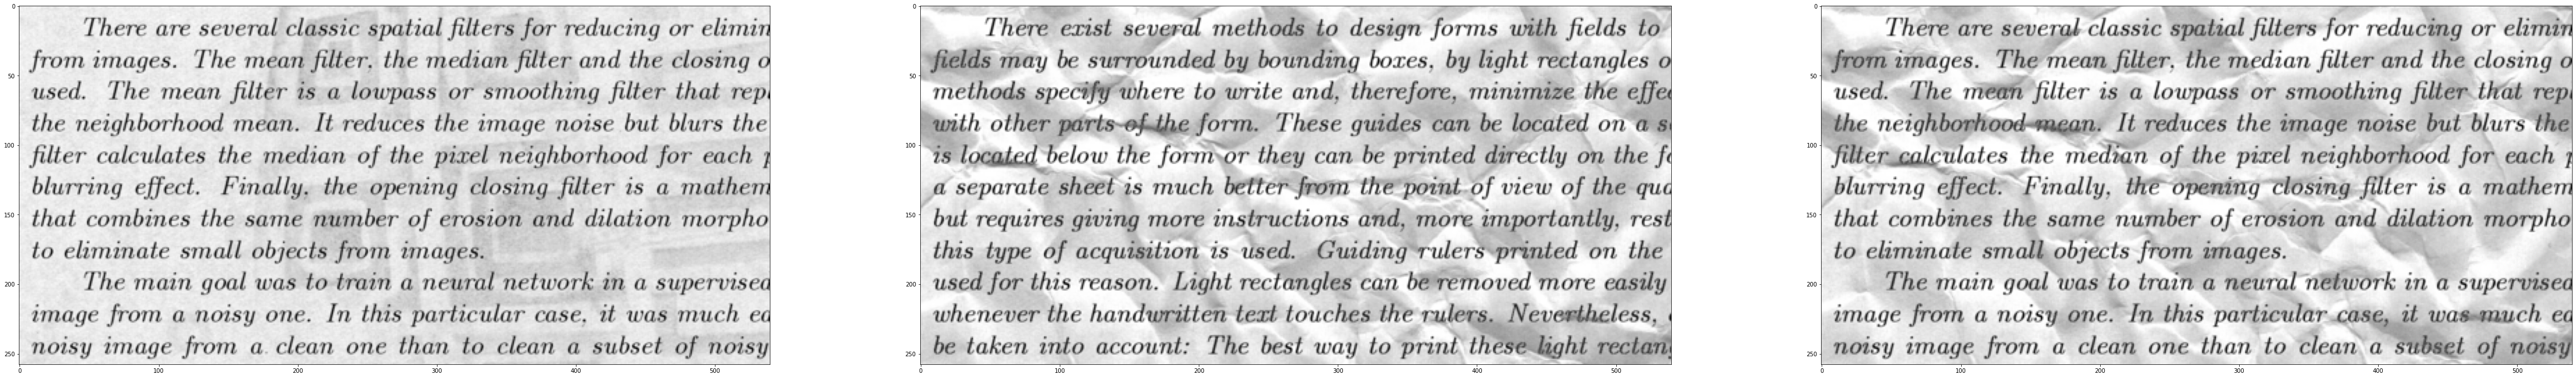

In [ ]:
f, ax = plt.subplots(1,3)
f.set_size_inches(80, 40)
for i in range(5,8):
    ax[i-5].imshow(x_train[i])

In [ ]:
![Autoencoders](https://cdn-images-1.medium.com/max/1600/1*ZEvDcg1LP7xvrTSHt0B5-Q@2x.png)

/bin/bash: -c: line 0: syntax error near unexpected token `https://cdn-images-1.medium.com/max/1600/1*ZEvDcg1LP7xvrTSHt0B5-Q@2x.png'
/bin/bash: -c: line 0: `[Autoencoders](https://cdn-images-1.medium.com/max/1600/1*ZEvDcg1LP7xvrTSHt0B5-Q@2x.png)'


In [ ]:
# Lets add sample noise - Salt and Pepper
noise = augmenters.SaltAndPepper(0.1)
seq_object = augmenters.Sequential([noise])

train_x_n = seq_object.augment_images(x_train * 255) / 255
val_x_n = seq_object.augment_images(x_test * 255) / 255
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5,10):
    ax[i-5].imshow(train_x_n[i, :, :, 0])

AssertionError: ignored

In [ ]:
# input layer
input_layer = Input(shape=(28, 28, 1))

# encoding architecture
encoded_layer1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
encoded_layer1 = MaxPool2D( (2, 2), padding='same')(encoded_layer1)
encoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded_layer1)
encoded_layer2 = MaxPool2D( (2, 2), padding='same')(encoded_layer2)
encoded_layer3 = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded_layer2)
latent_view    = MaxPool2D( (2, 2), padding='same')(encoded_layer3)
# decoding architecture
decoded_layer1 = Conv2D(16, (3, 3), activation='relu', padding='same')(latent_view)
decoded_layer1 = UpSampling2D((2, 2))(decoded_layer1)
decoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(decoded_layer1)
decoded_layer2 = UpSampling2D((2, 2))(decoded_layer2)
decoded_layer3 = Conv2D(64, (3, 3), activation='relu')(decoded_layer2)
decoded_layer3 = UpSampling2D((2, 2))(decoded_layer3)
output_layer   = Conv2D(1, (3, 3), padding='same')(decoded_layer3)
# compile the model
model = Model(input_layer, output_layer)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 16)          4624  

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=5, mode='auto')
history = model.fit(train_x_n, x_train, epochs=20, batch_size=2048, validation_data=(val_x_n, x_test), callbacks=[early_stopping])

Epoch 1/20
30/30 [==============================] - 241s 8s/step - loss: 0.0879 - val_loss: 0.0506
Epoch 2/20
19/30 [==================>...........] - ETA: 1:27 - loss: 0.0435

KeyboardInterrupt: ignored

In [ ]:
with open('small_vocab_en.txt') as f:
    english_sentences = f.readlines()

with open('small_vocab_fr.txt') as f:
    french_sentences = f.readlines()

print('Dataset Loaded')
for sample_i in range(2):
    print('small_vocab_en Line {}:  {}'.format(sample_i + 1, english_sentences[sample_i]))
    print('small_vocab_fr Line {}:  {}'.format(sample_i + 1, french_sentences[sample_i]))


Dataset Loaded
small_vocab_en Line 1:  new jersey is sometimes quiet during autumn , and it is snowy in april .

small_vocab_fr Line 1:  new jersey est parfois calme pendant l' automne , et il est neigeux en avril .

small_vocab_en Line 2:  the united states is usually chilly during july , and it is usually freezing in november .

small_vocab_fr Line 2:  les états-unis est généralement froid en juillet , et il gèle habituellement en novembre .



## Some information about the dataset

In [ ]:
english_words_counter = collections.Counter([word for sentence in english_sentences for word in sentence.split()])
french_words_counter = collections.Counter([word for sentence in french_sentences for word in sentence.split()])
epochs = 25
print('{} English words.'.format(len([word for sentence in english_sentences for word in sentence.split()])))
print('{} unique English words.'.format(len(english_words_counter)))
print('10 Most common words in the English dataset:')
print('"' + '" "'.join(list(zip(*english_words_counter.most_common(10)))[0]) + '"')
print()
print('{} French words.'.format(len([word for sentence in french_sentences for word in sentence.split()])))
print('{} unique French words.'.format(len(french_words_counter)))
print('10 Most common words in the French dataset:')
print('"' + '" "'.join(list(zip(*french_words_counter.most_common(10)))[0]) + '"')

1823250 English words.
227 unique English words.
10 Most common words in the English dataset:
"is" "," "." "in" "it" "during" "the" "but" "and" "sometimes"

1961295 French words.
355 unique French words.
10 Most common words in the French dataset:
"est" "." "," "en" "il" "les" "mais" "et" "la" "parfois"



## Preprocess

### Tokenize (IMPLEMENTATION)


In [ ]:
def tokenize(x):
    """
    Tokenize x
    :param x: List of sentences/strings to be tokenized
    :return: Tuple of (tokenized x data, tokenizer used to tokenize x)
    """
    x_tk = Tokenizer(char_level = False)
    x_tk.fit_on_texts(x)
    return x_tk.texts_to_sequences(x), x_tk

# Tokenize Example output
text_sentences = [
    'The quick brown fox jumps over the lazy dog .',
    'By Jove , my quick study of lexicography won a prize .',
    'This is a short sentence .']
text_tokenized, text_tokenizer = tokenize(text_sentences)
print(text_tokenizer.word_index)
print()
for sample_i, (sent, token_sent) in enumerate(zip(text_sentences, text_tokenized)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(sent))
    print('  Output: {}'.format(token_sent))

{'the': 1, 'quick': 2, 'a': 3, 'brown': 4, 'fox': 5, 'jumps': 6, 'over': 7, 'lazy': 8, 'dog': 9, 'by': 10, 'jove': 11, 'my': 12, 'study': 13, 'of': 14, 'lexicography': 15, 'won': 16, 'prize': 17, 'this': 18, 'is': 19, 'short': 20, 'sentence': 21}

Sequence 1 in x
  Input:  The quick brown fox jumps over the lazy dog .
  Output: [1, 2, 4, 5, 6, 7, 1, 8, 9]
Sequence 2 in x
  Input:  By Jove , my quick study of lexicography won a prize .
  Output: [10, 11, 12, 2, 13, 14, 15, 16, 3, 17]
Sequence 3 in x
  Input:  This is a short sentence .
  Output: [18, 19, 3, 20, 21]



### Padding (IMPLEMENTATION)



In [ ]:
def pad(x, length=None):
    """
    Pad x
    :param x: List of sequences.
    :param length: Length to pad the sequence to.  If None, use length of longest sequence in x.
    :return: Padded numpy array of sequences
    """
    # TODO: Implement
    if length is None:
        length = max([len(sentence) for sentence in x])
    return pad_sequences(x, maxlen = length, padding = 'post')

#tests.test_pad(pad)

# Pad Tokenized output
test_pad = pad(text_tokenized)
for sample_i, (token_sent, pad_sent) in enumerate(zip(text_tokenized, test_pad)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(np.array(token_sent)))
    print('  Output: {}'.format(pad_sent))

Sequence 1 in x
  Input:  [1 2 4 5 6 7 1 8 9]
  Output: [1 2 4 5 6 7 1 8 9 0]
Sequence 2 in x
  Input:  [10 11 12  2 13 14 15 16  3 17]
  Output: [10 11 12  2 13 14 15 16  3 17]
Sequence 3 in x
  Input:  [18 19  3 20 21]
  Output: [18 19  3 20 21  0  0  0  0  0]



### Preprocess Pipeline


In [ ]:
def preprocess(x, y):
    """
    Preprocess x and y
    :param x: Feature List of sentences
    :param y: Label List of sentences
    :return: Tuple of (Preprocessed x, Preprocessed y, x tokenizer, y tokenizer)
    """
    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)

    preprocess_x = pad(preprocess_x)
    preprocess_y = pad(preprocess_y)

    # Keras's sparse_categorical_crossentropy function requires the labels to be in 3 dimensions
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)

    return preprocess_x, preprocess_y, x_tk, y_tk

preproc_english_sentences, preproc_french_sentences, english_tokenizer, french_tokenizer =\
    preprocess(english_sentences, french_sentences)
    
max_english_sequence_length = preproc_english_sentences.shape[1]
max_french_sequence_length = preproc_french_sentences.shape[1]
english_vocab_size = len(english_tokenizer.word_index)
french_vocab_size = len(french_tokenizer.word_index)

print('Data Preprocessed')
print("Max English sentence length:", max_english_sequence_length)
print("Max French sentence length:", max_french_sequence_length)
print("English vocabulary size:", english_vocab_size)
print("French vocabulary size:", french_vocab_size)

Data Preprocessed
Max English sentence length: 15
Max French sentence length: 21
English vocabulary size: 199
French vocabulary size: 344


### Ids Back to Text


In [ ]:
def logits_to_text(logits, tokenizer):
    """
    Turn logits from a neural network into text using the tokenizer
    :param logits: Logits from a neural network
    :param tokenizer: Keras Tokenizer fit on the labels
    :return: String that represents the text of the logits
    """
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

print('`logits_to_text` function loaded.')

`logits_to_text` function loaded.


### predict function
Choose some random sentences and translate them using the given model

In [ ]:
def predict_some(model, tmp, input, output_tokenizer, how_many=10):
    # random 10
    nums = []
    for i in range(how_many):
        num = np.random.randint(0, tmp.shape[0] - 1)
        while num in nums:
            num = np.random.randint(0, tmp.shape[0] - 1)
        nums.append(num)
        print(i + 1, ': sentence num', num)
        print(input[num], end = '')
        prediction = model.predict(tmp[num:num + 1])
        print(logits_to_text(prediction[0], output_tokenizer))
        print()

### Preparing input data

In [ ]:
# Reshaping the input to work with a basic RNN
tmp_x = pad(preproc_english_sentences, max_french_sequence_length)
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2], 1))
print(tmp_x.shape[1:])

# Stacked RNN


## Compile Function

In [ ]:
# source: https://github.com/zahangircse/COMP_EECE_7or8740_NNs/blob/main/Assignment_4_ref_codes.ipynb
# https://github.com/zahangircse/COMP_EECE_7or8740_NNs/blob/main/Lecture_14_RNN.ipynb
def stacked_rnn(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a basic RNN on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    learning_rate = 1e-3
    input_seq = Input(input_shape[1:])
    rnn = SimpleRNN(64, return_sequences = True)(input_seq)
    rnn = SimpleRNN(64, return_sequences = True)(rnn)

    logits = TimeDistributed(Dense(french_vocab_size))(rnn)
    model = Model(input_seq, Activation('softmax')(logits))
    model.compile(loss = sparse_categorical_crossentropy, 
                 optimizer = Adam(learning_rate), 
                 metrics = ['accuracy'])
    
    return model


(21, 1)


## Train the model

In [ ]:
# Train the neural network
stacked_rnn_model = stacked_rnn(tmp_x.shape,
                                max_french_sequence_length,
                                english_vocab_size,
                                french_vocab_size + 1)

stacked_rnn_model.summary()

history_rnn = stacked_rnn_model.fit(tmp_x,
                     preproc_french_sentences,
                     batch_size=16,
                     epochs=epochs,
                     validation_split=0.2)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 21, 1)]           0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 21, 64)            4224      
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 21, 64)            8256      
_________________________________________________________________
time_distributed_6 (TimeDist (None, 21, 345)           22425     
_________________________________________________________________
activation_4 (Activation)    (None, 21, 345)           0         
Total params: 34,905
Trainable params: 34,905
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
6893/6893 [==============================] - 102s 15ms/step - loss: 1.3722 - accuracy: 0.6310 - val_loss: 1.11

## Accuracy and Loss Results

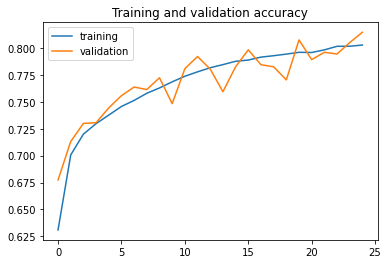

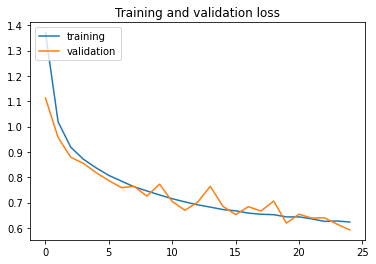

In [ ]:
plt.plot(history_rnn.history['accuracy'])
plt.plot(history_rnn.history['val_accuracy'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.title('Training and validation accuracy')
plt.show()

plt.plot(history_rnn.history['loss'])
plt.plot(history_rnn.history['val_loss'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.title('Training and validation loss')
plt.show()

## Translate ten random sentences using the model

# Stacked LSTM

In [ ]:
predict_some(stacked_rnn_model, tmp_x, english_sentences, french_tokenizer)

1 : sentence num 54331
france is sometimes wet during october , and it is never relaxing in february .
la france est parfois humide en octobre et il est jamais humide en février <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

2 : sentence num 32563
paris is sometimes freezing during january , and it is cold in july .
paris est parfois agréable gel en janvier et il est chaud en juillet <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

3 : sentence num 59266
paris is beautiful during fall , but it is sometimes busy in september .
paris est agréable en juin mais il est parfois occupé en juillet <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

4 : sentence num 24576
paris is usually cold during october , and it is usually chilly in june .
paris est généralement froid en octobre et il est généralement froid en juin <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

5 : sentence num 92230
paris is sometimes wet during november , but it is never hot in may .
paris est parfois humide en mois de 

In [ ]:
# source: https://machinelearningmastery.com/stacked-long-short-term-memory-networks/
# source: https://github.com/zahangircse/COMP_EECE_7or8740_NNs/blob/main/Assignment_4_ref_codes.ipynb

def stacked_lstm(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a basic RNN on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # TODO: Build the layers
    learning_rate = 1e-3
    input_seq = Input(input_shape[1:])
    rnn = LSTM(64, return_sequences = True)(input_seq)
    rnn = LSTM(64, return_sequences = True)(rnn)

    logits = TimeDistributed(Dense(french_vocab_size))(rnn)
    model = Model(input_seq, Activation('softmax')(logits))
    model.compile(loss = sparse_categorical_crossentropy, 
                 optimizer = Adam(learning_rate), 
                 metrics = ['accuracy'])
    
    return model





In [ ]:
# Train the neural network
stacked_lstm_model = stacked_lstm(tmp_x.shape,
                                max_french_sequence_length,
                                english_vocab_size,
                                french_vocab_size + 1)

stacked_lstm_model.summary()

history_lstm = stacked_lstm_model.fit(tmp_x,
                     preproc_french_sentences,
                     batch_size=16,
                     epochs=epochs,
                     validation_split=0.2)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 21, 1)]           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 21, 64)            16896     
_________________________________________________________________
lstm_5 (LSTM)                (None, 21, 64)            33024     
_________________________________________________________________
time_distributed_7 (TimeDist (None, 21, 345)           22425     
_________________________________________________________________
activation_5 (Activation)    (None, 21, 345)           0         
Total params: 72,345
Trainable params: 72,345
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
6893/6893 [==============================] - 166s 24ms/step - loss: 1.4320 - accuracy: 0.6205 - val_loss: 1.08

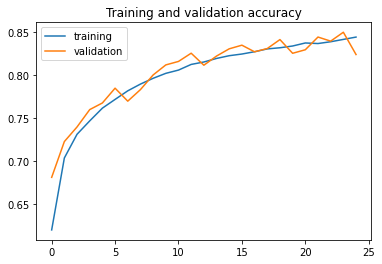

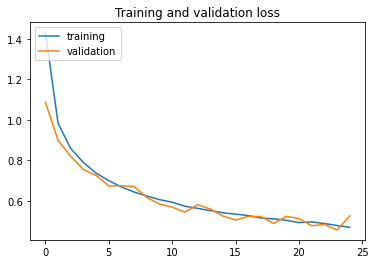

In [ ]:
plt.plot(history_lstm.history['accuracy'])
plt.plot(history_lstm.history['val_accuracy'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.title('Training and validation accuracy')
plt.show()

plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.title('Training and validation loss')
plt.show()

In [ ]:
print('maximum accuracy: %', round(np.max(history_lstm.history['accuracy']) * 100, 2), 'at iteration', np.argmax(history_lstm.history['accuracy']))

maximum accuracy: % 84.38 at iteration 24


In [ ]:
predict_some(stacked_lstm_model, tmp_x, english_sentences, french_tokenizer)

1 : sentence num 59885
india is sometimes wet during spring , but it is rainy in fall .
l' inde est parfois humide au printemps mais il est froid à l' automne <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

2 : sentence num 92618
california is never pleasant during winter , and it is sometimes hot in september .
californie est jamais agréable le gel pendant l' hiver et il est parfois calme en septembre <PAD> <PAD> <PAD> <PAD> <PAD>

3 : sentence num 105663
the united states is usually warm during august .
la états unis est généralement chaud en mois mois août août <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

4 : sentence num 125950
the united states is never wet during march , and it is pleasant in october .
la états unis est jamais doux en l' et il est il en octobre <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

5 : sentence num 41756
he dislikes grapefruit , apples , and strawberries .
il aime pas pamplemousse pamplemousse les mangues et poires <PAD> <PAD> <PAD> <PAD> <PAD> <P

# Stacked GRU

In [ ]:
# source: https://github.com/zahangircse/COMP_EECE_7or8740_NNs/blob/main/Assignment_4_ref_codes.ipynb

def stacked_gru(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a basic RNN on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # TODO: Build the layers
    learning_rate = 1e-3
    input_seq = Input(input_shape[1:])
    rnn = GRU(64, return_sequences = True)(input_seq)
    rnn = GRU(64, return_sequences = True)(rnn)

    logits = TimeDistributed(Dense(french_vocab_size))(rnn)
    model = Model(input_seq, Activation('softmax')(logits))
    model.compile(loss = sparse_categorical_crossentropy, 
                 optimizer = Adam(learning_rate), 
                 metrics = ['accuracy'])
    
    return model


#tests.test_simple_model(simple_model)

# Reshaping the input to work with a basic RNN
tmp_x = pad(preproc_english_sentences, max_french_sequence_length)
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2], 1))
print(tmp_x.shape[1:])

In [ ]:
# Train the neural network
stacked_gru_model = stacked_gru(tmp_x.shape,
                                max_french_sequence_length,
                                english_vocab_size,
                                french_vocab_size + 1)

stacked_gru_model.summary()

history_gru = stacked_gru_model.fit(tmp_x,
                     preproc_french_sentences,
                     batch_size=16,
                     epochs=epochs,
                     validation_split=0.2)

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 21, 1)]           0         
_________________________________________________________________
gru_6 (GRU)                  (None, 21, 64)            12864     
_________________________________________________________________
gru_7 (GRU)                  (None, 21, 64)            24960     
_________________________________________________________________
time_distributed_8 (TimeDist (None, 21, 345)           22425     
_________________________________________________________________
activation_6 (Activation)    (None, 21, 345)           0         
Total params: 60,249
Trainable params: 60,249
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
6893/6893 [==============================] - 143s 20ms/step - loss: 1.3642 - accuracy: 0.6338 - val_loss: 1.03

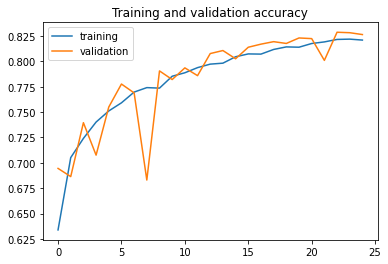

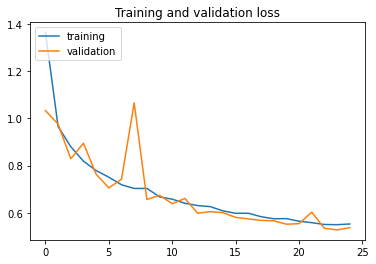

In [ ]:
plt.plot(history_gru.history['accuracy'])
plt.plot(history_gru.history['val_accuracy'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.title('Training and validation accuracy')
plt.show()

plt.plot(history_gru.history['loss'])
plt.plot(history_gru.history['val_loss'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.title('Training and validation loss')
plt.show()

In [ ]:
predict_some(stacked_lstm_model, tmp_x, english_sentences, french_tokenizer)

1 : sentence num 47020
china is cold during spring , and it is never mild in march .
chine est froid en printemps et il est jamais doux en l' <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

2 : sentence num 64270
the united states is never wonderful during fall , but it is usually pleasant in february .
la états unis est jamais merveilleux sec à cours automne mais il mais généralement en en <PAD> <PAD> <PAD> <PAD> <PAD>

3 : sentence num 103291
they like mangoes , strawberries , and lemons.
ils aiment les les les les et les citrons <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

4 : sentence num 13508
the orange is her most loved fruit , but the banana is their most loved .
la est est son fruit le plus aimé mais la chaux est plus plus aimé <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

5 : sentence num 17116
the strawberry is his least liked fruit , but the grape is our least liked .
la fraise est son fruit aimé des fruits mais le raisin est notre aimé aimé <PAD> 